# PWM calculations

## What is the signal I need to generate?

### Scope traces

The Arduino servo library is for ATmega328p so I can't use it directly. I hooked up my scope and ran some very simple code on an Arduino that just sets the servo to a constant angle.

Here's the PWM output going to the servo when set to 20 degrees:

![alt text](scope-traces/pwm-for-servo/angle-20.png "Title")

40 degrees:

![alt text](scope-traces/pwm-for-servo/angle-40.png "Title")

Here's 100 degrees:

![alt text](scope-traces/pwm-for-servo/angle-100.png "Title")

140 degrees:

![alt text](scope-traces/pwm-for-servo/angle-140.png "Title")

160 degrees:

![alt text](scope-traces/pwm-for-servo/angle-160.png "Title")

And here's 180 degrees:


![alt text](scope-traces/pwm-for-servo/angle-180.png "Title")

So we're looking at base 50Hz signal and a duty cycle that varies from about 3% to 12%.

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

angle_duty = np.array([[20.,40,100,140,160,180], [3.509, 4.511, 7.519, 9.524, 10.53, 12.03]])

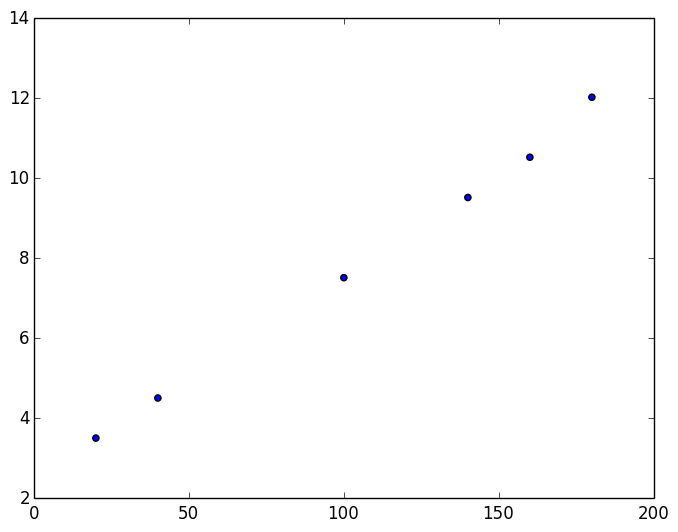

In [12]:
plt.scatter(angle_duty[0,:], angle_duty[1,:])

In [15]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(angle_duty[0,], angle_duty[1,])

0.0518575 2.4057 0.998741743524 2.37381799585e-06 0.00130194100889


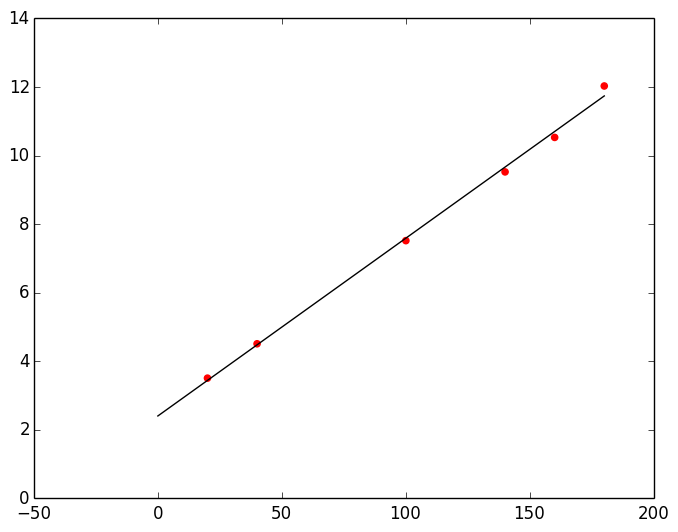

In [20]:
print slope, intercept, r_value, p_value, std_err
xs = np.linspace(0,180,100)
ys = slope*xs + intercept
plt.plot(xs,ys, color='black')
plt.scatter(angle_duty[0,:], angle_duty[1,:], color='red')

### Summary of requirements

Generate a 50Hz PWM signal with a duty cycle between 2.5% and 12%, where every additional percentage point in duty cycle rotates the motor by 20 degrees.

Let $d$ be the duty cycle in percentage points and $a$ the desired angle in degrees. Then

$$
d = 2.41 + 0.0519a
$$

Let $d$ be the desired duty cycle in percentage points and $l$ the width of the pulse in milliseconds. Then $l = d*20/100$, so in terms of the desired angle $a$,

$$
l = 0.482 + 0.0103715a
$$

Checking the equation above:

In [34]:
def pulse_width(a):
    return 0.482 + 0.0103715*a
angles = np.array([100., 140, 160, 180])
print pulse_width(angles)

[ 1.51915  1.93401  2.14144  2.34887]


## Can I use one of the PWM modes on Timer/Counter0?

Here's how I think PWM works on this chip.

The tricky thing: in the modes where TOP isn't 0xFF, TOP=OCR0A _specifically_, even for output pin B.

If you're happy with a PWM frequency that's a power-of-2 factor of the system clock frequency, you pick that prescaler value, choose one of the modes where TOP=0xFF and you can use both output pins A and B (PB0 and PB1 ie. pins 5 and 6) sort of independently. You get the best resolution with this method.

![alt text](pwm-pins.png "Title")
![alt text](pinout.png "Title")

If you need a custom frequency that's between one of the power-of-2 factors, you can only get a useful PWM output on output pin B (PB1 ie. pin 6). You select a prescaler that would result in a frequency that's just a bit too slow. You select a mode where TOP=OCR0A. You set OCR0A to the value that gives the right base frequency. You set OCR0B to the value that gives the right pulse width (smaller than OCR0A).

The resolution you with the second method get varies between 1/254 and 1/128. In the best case, the frequency you want is just a tad more than what you'd get by dividing base clock (1MHz) by the prescaler and then counting to 255. Then you get to use almost the full 8 bit range of TCNT0. In the worst case you 

### What would the prescaler and configuration have to be?

We will run the microcontroller at 1MHz (lower power consumption). 

In hardware PWM mode we run the overall system clock through a prescaler, which emits one tick for every $n$ system clock ticks.

On Counter0 the available prescale $n$'s are 1, 8, 64, 256 and 1024.

Every tick out of the prescaler causes TCNT0 to increase by one. When TCNT0 reaches OCR0B, the pin turns off. When TCNT0 reacher OCR0A, the pin goes back on.

In [21]:
1000000/1024

976

976 Hz. That means we would have to use a TOP value of

In [23]:
50*255./976

13.063524590163935

and every increment in the value of the output compare register would increase duty cycle by

In [25]:
100./13

7.6923076923076925

which increases angle by

In [26]:
2000./13

153.84615384615384

That's awfully low resolution -- basically just two states of the motor will be accessible. That's probably fine for a very primitive switch but I think I'll need a little more. That's because I still want to be able to turn the switch on and off by hand, and in that case the servo horn has to hit the switch and then back away.

So I'll have to generate the PWM signal in software.

### Summary

A frequency of 50Hz is too low for me to use one of the hardware PWM modes, because the chip is running 20,000 times faster; the strongest prescaling only reduces that by a factor of 1024, which means I need to use the 8-bit counter to remove the remaining ~20x; by then, there's not much resolution left.

## Software PWM

Suppose we wanted to have a resolution of 10 degrees for the servo. Then since $w = 0.482 + 0.0103715a$, where $w$ is the pulse width in milliseconds, we need to generate pulses with a resolution of 0.103715ms, which is about 100 microseconds.

The fastest timescale is 100 microseconds (pulse width difference needed to achieve 10 degree resolution), and the slowest is 20ms (time period of the PWM signal to the motor) ie. 200x the fastest time.

At 1MHz, the ATTiny85 executes an instruction every microsecond. So we have a 100 cycle budget for the timer interrupt.

### What options do I have from using the prescaler?

The available modes are 1, 8, 64, 256 and 1024. 

With 12 ticks with a prescaler of 8, we'd be within 4% of the desired accuracy (a tick every 96 cycles).

With 2 ticks with a prescaler of 64, we'd be within 28% of the desired accuracy (a tick every 128 cycles).

### How should we set up the timers?

We have several paths.

#### A single timer interrupt at fixed frequency

Just use one timer that runs about once every 100us, which becomes the base tick-size of the system. 

Every tick it increments a counter.

Every several ticks, it turns the motor pin on or off to achieve PWM. 

Every several ticks, it checks the IR receiver's state and advances the communication state-machine.

A shared base timer for the entire application makes sense because the fastest events in IR signalling also happen in the 100us to 1ms timescale (after demodulation of the 38KHz carrier signal, which the integrated TSOP module takes care of for us).

For PWM control, the counter only needs to go up to 200 before wrapping around, which fits nicely in 8 bits.

With this strategy there is systematic error: we will have stable PWM, but the width will be systematically more or less than what we wanted to set it to.

#### Two timers at fixed frequencies

One timer just counts microseconds since startup; the other actually runs/schedules tasks.

The first timer can run entirely in hardware most of the time, with an interrupt only when the counter overflows. That interrupt would reset the counter and increment a high-bits counter.

The second timer fires an interrupt every time, looks at the time, and decided whether to run one or both of the tasks.

This strategy will still have timing error, but it won't be systematic: sometimes the second timer wakes up too early, sometimes it wakes up too late, but both times it can decide to run the PWM task if it's close to the right window.

If we're very clever we can probably write the PWM task in a way that achieves zero error by inserting nops and counting cycles.

#### Mixed-frequency timer interrupt for PWM

We devote a timer to PWM. It toggles between two states: waiting to turn the pin on, and waiting to turn it off.

Whenever it wakes up, it toggles the servo output pin and then sets its own timer compare register so that it wakes back up when it's time to toggle the pin again. 

We have to be a little careful here if we want to generate the perfect signal even when the pulse width changes while the timer is sleeping. Such single-pulse accuracy is not important for the current application.

We can get basically perfect 1 microsecond accuracy with this strategy.

This could be a very low-power approach if implemented carefully.

We would need another timer to handle IR communication.

#### Mixed-frequency timer with a scheduler

An more sophisticated version of the previous strategy would be to have a scheduler that knows about all the tasks we want to run, and in particular the one that needs to run soonest. Then it sets OCR to so as to wake up when it's time to run that task.

This could achieve low power, good timing accuracy and use only one timer to handle all the tasks in the system. But it would be more complex to implement.



## Hardware PWM with Timer/Counter1

So far I had ignored the second of ATTiny85's two timers, assuming it was much like the first. But idly reading the ATTiny85 datasheet today, I discovered that this timer has lots of additional prescaling modes!

That's exactly what we need to generate low-frequency, highish-accuracy PWM to control the servo.

### Which prescaling mode?

In [35]:
1000000/16384 # base frequency 

61

In [36]:
50./61 * 255

209.01639344262296

In [37]:
100./209

0.4784688995215311